In [12]:
import csv
import datetime
import h5py
import keras
import numpy as np
import os
import pandas as pd
import pescador
import sys
import tensorflow as tf
import time

import sys
sys.path.append("../src")
import localmodule

# Define constants.
dataset_name = localmodule.get_dataset_name()
folds = localmodule.fold_units()
models_dir = localmodule.get_models_dir()
n_input_hops = 104
n_filters = [24, 48, 48]
kernel_size = [5, 5]
pool_size = [2, 4]
n_hidden_units = 64
steps_per_epoch = 256
epochs = 32
validation_steps = 256
batch_size = 32
n_context_classes = 4


# Read command-line arguments.
args = ["3600", "unit01"]
aug_kind_str = "original"
bg_duration = int(args[0])
unit_str = args[1]


# Retrieve fold such that unit_str is in the test set.
fold = [f for f in folds if unit_str in f[0]][0]
test_units = fold[0]
training_units = fold[1]
validation_units = fold[2]


# Print header.
start_time = int(time.time())
print(str(datetime.datetime.now()) + " Start.")
print("Training Salamon's ICASSP 2017 convnet on " + dataset_name + ". ")
print("Training set: " + ", ".join(training_units) + ".")
print("Validation set: " + ", ".join(validation_units) + ".")
print("Test set: " + ", ".join(test_units) + ".")
print("")
print('h5py version: {:s}'.format(h5py.__version__))
print('keras version: {:s}'.format(keras.__version__))
print('numpy version: {:s}'.format(np.__version__))
print('pandas version: {:s}'.format(pd.__version__))
print('pescador version: {:s}'.format(pescador.__version__))
print('tensorflow version: {:s}'.format(tf.__version__))
print("")


# Define and compile Keras model.
# NB: the original implementation of Justin Salamon in ICASSP 2017 relies on
# glorot_uniform initialization for all layers, and the optimizer is a
# stochastic gradient descent (SGD) with a fixed learning rate of 0.1.
# Instead, we use a he_normal initialization for the layers followed
# by rectified linear units (see He ICCV 2015), and replace the SGD by
# the Adam adaptive stochastic optimizer (see Kingma ICLR 2014).
# Moreover, we disable dropout because we found that it consistently prevented
# the model to train at all.

# Main channel.
# Input
spec_input = keras.layers.Input(
    shape=(128, n_input_hops, 1), name="spec_input")

# Layer 1
spec_bn = keras.layers.normalization.BatchNormalization(
    name="spec_bn")(spec_input)
spec_conv1 = keras.layers.Convolution2D(n_filters[0], kernel_size,
    padding="same", kernel_initializer="he_normal",
    name="spec_conv1")(spec_bn)
spec_pool1 = keras.layers.MaxPooling2D(
    pool_size=pool_size, name="spec_pool1")(spec_conv1)

# Layer 2
spec_conv2 = keras.layers.Convolution2D(n_filters[1], kernel_size,
    padding="same", kernel_initializer="he_normal",
    activation="relu", name="spec_conv2")(spec_pool1)
spec_pool2 = keras.layers.MaxPooling2D(
    pool_size=pool_size, name="spec_pool2")(spec_conv2)

# Layer 3
spec_conv3 = keras.layers.Convolution2D(n_filters[2], kernel_size,
    padding="same", kernel_initializer="he_normal",
    activation="relu", name="spec_conv3")(spec_pool2)

# Layer 4
spec_flatten = keras.layers.Flatten(
    name="spec_flatten")(spec_conv3)
spec_dense = keras.layers.Dense(n_hidden_units,
    kernel_initializer="he_normal", activation="relu",
    kernel_regularizer=keras.regularizers.l2(0.001),
    name="spec_dense1")(spec_flatten)

# Reshape.
spec_reshape = keras.layers.Reshape((-1, 4),
    name="spec_reshape")(spec_dense)


# Side channel.
# Input
bg_input = keras.layers.Input(
    shape=(128, 5), name="bg_input")

# Pool
bg_pool = keras.layers.AveragePooling1D(
    pool_size=4, name="bg_pool")(bg_input)

# Permute
bg_permute = keras.layers.Permute(
    (2, 1), name="bg_permute")(bg_pool)

# Conv
bg_conv = keras.layers.Conv1D(
    8, 1, kernel_initializer="he_normal",
    activation="relu", name="bg_conv")(bg_permute)

# Flatten
bg_flatten = keras.layers.Flatten(
    name="bg_flatten")(bg_conv)

# Dense 1
bg_dense1 = keras.layers.Dense(16,
    kernel_initializer="he_normal",
    activation="relu", name="bg_dense1")(bg_flatten)

# Dense 2
bg_dense2 = keras.layers.Dense(4,
    kernel_initializer="he_normal",
    activation="softmax", name="bg_dense2")(bg_dense1)

# Reshape
bg_reshape = keras.layers.Reshape((1, 4),
    name="bg_reshape")(bg_dense2)


# Element-wise multiplication
multiply = keras.layers.Multiply(
    name="multiply")([spec_reshape, bg_reshape])

# Flatten
flatten = keras.layers.Flatten(
    name="flatten")(multiply)


# Layer 5
# We put a single output instead of 43 in the original paper, because this
# is binary classification instead of multilabel classification.
# Furthermore, this layer contains 43 times less connections than in the
# original paper, so we divide the l2 weight penalization by 50, which is
# of the same order of magnitude as 43.
# 0.001 / 50 = 0.00002
dense = keras.layers.Dense(1,
    kernel_initializer="normal", activation="sigmoid",
    kernel_regularizer=keras.regularizers.l2(0.00002),
    name="dense")(flatten)


# Compile model, print model summary.
inputs = [spec_input, bg_input]
model = keras.models.Model(inputs=inputs, outputs=dense)
model.compile(loss="binary_crossentropy",
    optimizer="adam", metrics=["accuracy"])
model.summary()

2017-11-25 19:51:24.208944 Start.
Training Salamon's ICASSP 2017 convnet on BirdVox-70k. 
Training set: unit02, unit03, unit05.
Validation set: unit07, unit10.
Test set: unit01.

h5py version: 2.6.0
keras version: 2.0.6
numpy version: 1.13.1
pandas version: 0.20.3
pescador version: 1.0.0
tensorflow version: 1.2.1

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
spec_input (InputLayer)          (None, 128, 104, 1)   0                                            
____________________________________________________________________________________________________
spec_bn (BatchNormalization)     (None, 128, 104, 1)   4           spec_input[0][0]                 
____________________________________________________________________________________________________
spec_conv1 (Conv2D)              (None, 128, 104, 24)  624         spec_bn[0][

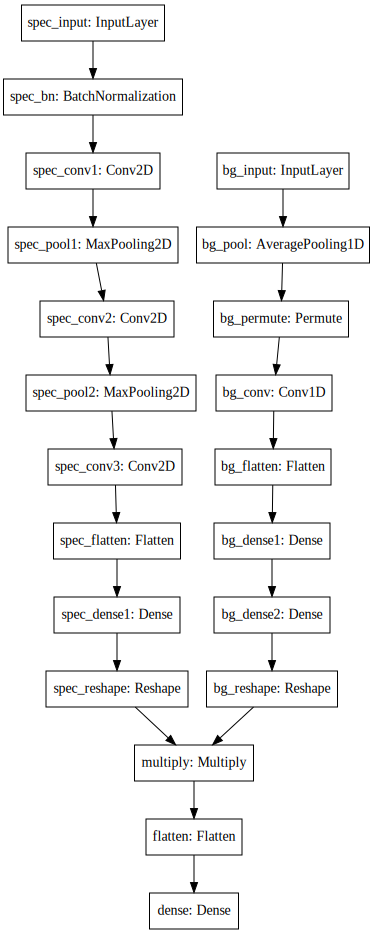

In [17]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))